In [1]:
import random
# import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
import argparse

import pdb

from model import *
from metrics import *
from dataset import *
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras import backend as K
from functools import wraps

from scipy.optimize import fmin_l_bfgs_b

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
# Config
tf.set_random_seed(777)

# os.environ["CUDA_VISIBLE_DEVICES"]=device
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

In [3]:
# Parameters
test_name = "0x0x-test-x"
device = "0"
model_type = "U"
data = "chd"
option = "train"
image_size = 256
batch_size = 5#16
epochs = 50
learning_rate = 0.0001
num_classes = 4
base = 32
scale = 2
which_target = 1

In [4]:
# Setting base directory 
base_dir = './input/chd'
x_train_dir = os.path.join(base_dir, 'x_train', 'class')
x_valid_dir = os.path.join(base_dir, 'x_valid', 'class')
x_test_dir = os.path.join(base_dir, 'x_test', 'class')
y_train_dir = os.path.join(base_dir, 'y_train', 'class')
y_valid_dir = os.path.join(base_dir, 'y_valid', 'class')
y_test_dir = os.path.join(base_dir, 'y_test', 'class')

In [5]:
x_folders = os.listdir(x_train_dir)
x_folders = sorted(x_folders)
y_folders = os.listdir(y_train_dir)
y_folders = sorted(y_folders)

In [6]:
print(x_folders[0], y_folders[0])

dia_002_000.jpg dia_002_000.jpg


In [ ]:
# from PIL import Image
# print('Pillow Version:', PIL.__version__)

### 1. Preprocessing

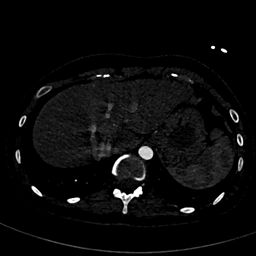

In [23]:
image_x = Image.open(os.path.join(x_train_dir, x_folders[0]))
image_x = image_x.resize((image_size, image_size))
image_x

In [24]:
x_= np.asarray(image_x)
x_sample = np.copy(x_sample)
x_sample.shape

(256, 256)

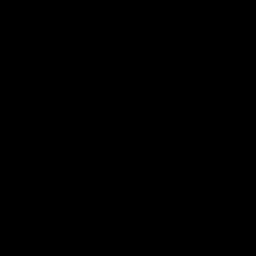

In [25]:
image_y = Image.open(os.path.join(y_train_dir, y_folders[0]))
image_y = image_y.resize((image_size, image_size))
image_y

In [27]:
y_sample = np.asarray(image_y)
y_sample = np.copy(y_sample)
y_sample.shape

(256, 256)

In [30]:
# need to preprocess Y (to have labels)

def creating_y_label(label):
# for (img,label) in data_gen:
    label[label < 50] = 0
    label[(label >= 50) & (label < 112.5)] = 75
    label[(label >= 112.5) & (label < 187.5)] = 150
    label[label >= 187.5] = 225
    label[label==75] = 1
    label[label==150] = 2
    label[label==225] = 3
#     label_adv = label
        # label_adv[label_adv==which_target] = 0 # YJS added
    label = to_categorical(label, num_classes=num_classes)
    return label

y_label = creating_y_label(y_sample)
y_label.shape

(256, 256, 4)

In [88]:
def targeted_label(label): # 일단은 다 0으로 만드는 adversarial attack
    label[label < 50] = 0
    label[(label >= 50) & (label < 112.5)] = 75
    label[(label >= 112.5) & (label < 187.5)] = 150
    label[label >= 187.5] = 225
    label[label==75] = 0
    label[label==150] = 0
    label[label==225] = 0
    label = to_categorical(label, num_classes=num_classes)
    return label
y_targeted = targeted_label(y_sample)
y_targeted.shape

(256, 256, 4)

In [ ]:
# model.compile(loss=dice_categorical_crossentropy,
#                   optimizer=keras.optimizers.Adam(lr=learning_rate, decay=0.0),
#                   metrics=[dice_coef, dice_coef_1, dice_coef_2, dice_coef_3, 
#                            adv_dice_coef])

In [31]:
model = load_model(filepath="./save/"+str(test_name)+"_"+data+".hdf5",
               custom_objects={'dice_categorical_crossentropy': dice_categorical_crossentropy,
                               'dice_coef': dice_coef,
                               'dice_coef_1': dice_coef_1,
                               'dice_coef_2': dice_coef_2,
                               'dice_coef_3': dice_coef_3,
                               'Scale': scale})










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [70]:
x_sample2 = x_sample.reshape(1, image_size, image_size, 1)
x_sample2.shape
y_label2 = y_label.reshape(1, image_size, image_size, 4)
y_label2.shape

(1, 256, 256, 4)

In [74]:
aaa = model.evaluate(x_sample2, y_label2)

1/1 [==============================] - 0s 22ms/step


In [77]:
b=aaa[0]

In [72]:
model.metrics_names

['loss', 'dice_coef', 'dice_coef_1', 'dice_coef_2', 'dice_coef_3']

In [100]:
from keras.losses import categorical_crossentropy
def func2(params, *args): #우리가 구하려는건 model의 weights가 아니라 x_adv
    params = np.clip(params, 0, 1)
    params = params.flatten()
    
    x = args[0]
    y = args[1]
    model = args[2]
    
    x = x.flatten()
    x_adv = x + params
    
    x_adv = x_adv.reshape((1,image_size,image_size,1))
    y = y.reshape((1,image_size,image_size,num_classes))

    loss = model.evaluate(x=x_adv, y=y, verbose=0)
    #grad = tf.gradients(loss, x_adv)
    return loss[0]#, grad

In [35]:
mybounds = [(None,2), (None,None)]
max_iter = 2

In [36]:
initial_image = np.zeros(np.shape(x_sample))

In [91]:
oimgs = np.clip(x_sample, 0, 1)
oimgs_flatten = oimgs.flatten()
oimgs_flatten.shape

(65536,)

In [37]:
ini = initial_image.flatten()
ini.shape

(65536,)

In [38]:
x1 = x_sample.flatten()
y1 = y_label.flatten()

In [101]:
adv_x, _, __ = fmin_l_bfgs_b(func2, x0=oimgs_flatten, args=(x_sample,y_targeted, model), approx_grad=True, maxiter = 2, disp=101)

# 여기에 이제 targeted label 추가

In [103]:
adv_x.shape

(65536,)

In [105]:
np.median(adv_x)

0.0

In [ ]:
np.save('sample_advimg.npy', )

In [106]:
pwd

'/home/taejoon/Workspace/AdvMedSeg'